In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops,hog
import albumentations as A
import glob
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from skimage.measure import  shannon_entropy
from scipy.stats import skew, kurtosis
import pywt


feature_names=[]

c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Hàm ánh xạ ảnh cropped qua ảnh gốc

In [6]:
# import os
# import glob

# def map_image_paths(no_bg_pattern, original_dir):
#     """Ánh xạ ảnh từ thư mục tách nền sang ảnh gốc (PNG)."""
#     mapping = {}

#     # Tạo dictionary chứa tên file gốc (không hậu tố)
#     original_images = {os.path.splitext(os.path.basename(p))[0]: p
#                        for p in glob.glob(os.path.join(original_dir, "**", "*.png"), recursive=True)}

#     # Duyệt qua các ảnh PNG đã tách nền
#     no_bg_files = glob.glob(no_bg_pattern)
#     print(f"🔍 Tìm thấy {len(no_bg_files)} ảnh trong cropped_mushrooms")

#     for no_bg_path in no_bg_files:
#         filename_no_ext = os.path.splitext(os.path.basename(no_bg_path))[0]  # Lấy tên file không đuôi
#         # filename_no_ext_clean = filename_no_ext.rsplit("_", 1)[0]  # Xóa hậu tố `_0`, `_1`,...

#         if filename_no_ext in original_images:  # Nếu tìm thấy ảnh gốc
#             mapping[no_bg_path] = original_images[filename_no_ext]
#         else:
#             print(f"⚠ Không tìm thấy file gốc cho: {filename_no_ext}")

#     return mapping

# # Cập nhật lại đường dẫn đúng
# no_bg_pattern = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Notebook\5_grab_cut_PNG\*/*.png"
# original_dir = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Mushrooms_PNG"

# # Chạy ánh xạ
# image_mapping = map_image_paths(no_bg_pattern, original_dir)

# # In 5 ánh xạ đầu tiên
# print("🗺 Một số ánh xạ:", list(image_mapping.items())[:5])


In [2]:

def map_image_paths(no_bg_pattern, original_dir):
    """Ánh xạ ảnh từ thư mục tách nền sang ảnh gốc (JPG)."""
    mapping = {}

    # Tạo dictionary chứa tên file gốc (không hậu tố)
    original_images = {os.path.splitext(os.path.basename(p))[0]: p
                       for p in glob.glob(os.path.join(original_dir, "**", "*.jpg"), recursive=True)}

    # Duyệt qua các ảnh JPG đã tách nền
    no_bg_files = glob.glob(no_bg_pattern)
    print(f"🔍 Tìm thấy {len(no_bg_files)} ảnh trong cropped_mushrooms")

    for no_bg_path in no_bg_files:
        filename_no_ext = os.path.splitext(os.path.basename(no_bg_path))[0]  # Lấy tên file không đuôi
        # filename_no_ext_clean = filename_no_ext.rsplit("_", 1)[0]  # Xóa hậu tố `_0`, `_1`,...
        filename_no_ext_clean = filename_no_ext
        if filename_no_ext_clean in original_images:  # Nếu tìm thấy ảnh gốc
            mapping[no_bg_path] = original_images[filename_no_ext_clean]
        else:
            print(f"⚠ Không tìm thấy file gốc cho: {filename_no_ext}")

    return mapping

# Cập nhật lại đường dẫn đúng
no_bg_pattern = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\5_grabcut_nobg_62\*/*.jpg"
original_dir = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Mushrooms"

# Chạy ánh xạ
image_mapping = map_image_paths(no_bg_pattern, original_dir)

# In 5 ánh xạ đầu tiên
print("🗺 Một số ánh xạ:", list(image_mapping.items())[:5])


🔍 Tìm thấy 6600 ảnh trong cropped_mushrooms
🗺 Một số ánh xạ: [('C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\5_grabcut_nobg_62\\Agaricus\\000_ePQknW8cTp8.jpg', 'C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\Mushrooms\\Agaricus\\000_ePQknW8cTp8.jpg'), ('C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\5_grabcut_nobg_62\\Agaricus\\001_2jP9N_ipAo8.jpg', 'C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\Mushrooms\\Agaricus\\001_2jP9N_ipAo8.jpg'), ('C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\5_grabcut_nobg_62\\Agaricus\\002_hNh3aQSH-ZM.jpg', 'C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\Mushrooms\\Agaricus\\002_hNh3aQSH-ZM.jpg'), ('C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\5_grabcut_nobg_62\\Agaricus\\003_4AurAO4Jil8.jpg', 'C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\Mushrooms\\Agaricus\\003_4AurAO4Jil8.jpg'), ('C:\\Users\\DO TUAN MINH\\Desktop\\ben\\Learn\\AIL303m\\5_grabcut_nobg_62\\Agaricus\\004_Syi3NxxviC0.jpg'

In [8]:


def debug_check_files(directory, extension):
    """Hàm debug: Liệt kê file trong thư mục"""
    files = glob.glob(os.path.join(directory, "**", f"*.{extension}"), recursive=True)
    print(f"📂 Đã tìm thấy {len(files)} ảnh {extension} trong {directory}")
    return files

# Kiểm tra file trong thư mục Mushrooms_PNG
png_files = debug_check_files(r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Mushrooms_PNG", "png")

# Kiểm tra file trong thư mục cropped_mushrooms
cropped_png_files = debug_check_files(r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Notebook\5_grab_cut_PNG", "png")
print("📌 Một số ảnh PNG trong Mushrooms_PNG:", [os.path.basename(f) for f in png_files][:5])
print("📌 Một số ảnh PNG trong cropped_mushrooms:", [os.path.basename(f) for f in cropped_png_files][:5])



📂 Đã tìm thấy 6714 ảnh png trong C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Mushrooms_PNG
📂 Đã tìm thấy 6671 ảnh png trong C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Notebook\5_grab_cut_PNG
📌 Một số ảnh PNG trong Mushrooms_PNG: ['000_ePQknW8cTp8.png', '001_2jP9N_ipAo8.png', '002_hNh3aQSH-ZM.png', '003_4AurAO4Jil8.png', '004_Syi3NxxviC0.png']
📌 Một số ảnh PNG trong cropped_mushrooms: ['000_ePQknW8cTp8.png', '001_2jP9N_ipAo8.png', '002_hNh3aQSH-ZM.png', '003_4AurAO4Jil8.png', '004_Syi3NxxviC0.png']


# Các hàm trích xuất feature

In [ ]:

def augment_image(image, image_bg):
    image_bg = cv2.resize(image_bg, (image.shape[1], image.shape[0]))  # Resize về cùng kích thước

    transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    
    A.Rotate(limit=10, p=0.3),
    ], additional_targets={"image_bg": "image"})
    augmented = transform(image=image, image_bg=image_bg)
    return augmented["image"], augmented["image_bg"]

def apply_gabor(img, ksize=31, sigma=5, lambd=10, gamma=0.5, psi=0):
    """Áp dụng bộ lọc Gabor lên ảnh."""
    theta_vals = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 4 hướng chính
    features = []
    
    for theta in theta_vals:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
        filtered_img = cv2.filter2D(img, cv2.CV_32F, kernel)
        features.append(np.mean(filtered_img))  # Lấy giá trị trung bình
    
    return np.array(features)

def extract_gist_custom(image, grid_size=4):
    """Trích xuất đặc trưng GIST bằng Gabor Filter + Fourier Transform từ ảnh đã đọc."""
    # img = cv2.resize(image, (256, 256))  # Resize về kích thước cố định
    img=image
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Chuyển về grayscale nếu cần

    h, w = img.shape
    cell_h, cell_w = h // grid_size, w // grid_size
    gist_features = []

    for i in range(grid_size):
        for j in range(grid_size):
            cell = img[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            gabor_features = apply_gabor(cell)
            gist_features.extend(gabor_features)
    
    return np.array(gist_features)

def extract_glcm_features_from_masked(image, mask, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # if mask is None:
    #     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Dùng toàn bộ ảnh nếu không có mask
    # else:
    #     gray = cv2.bitwise_and(image, image, mask=mask)

    # coords = np.column_stack(np.where(gray > 0))  # Tìm pixel có giá trị trong ảnh

    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
    coords = np.column_stack(np.where(mask > 0))
    
    if coords.shape[0] == 0:
        return np.zeros(5 * len(distances) * len(angles))  

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    cropped_gray = masked_gray[x_min:x_max+1, y_min:y_max+1]

    # Kiểm tra kích thước hợp lệ
    if cropped_gray.size < 2:
        return np.zeros(5 * len(distances) * len(angles))

    # Đảm bảo kiểu dữ liệu là uint8
    cropped_gray = cropped_gray.astype(np.uint8)

    glcm = graycomatrix(cropped_gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    feature_values = [graycoprops(glcm, prop).flatten() for prop in properties]

    features = np.hstack(feature_values).flatten()  
    expected_length = 5 * len(distances) * len(angles)  
    if len(features) != expected_length:
        features = np.pad(features, (0, expected_length - len(features)))  
    
    return features


def extract_sift_features(image, mask):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    sift = cv2.SIFT_create()  # Chỉ lấy tối đa keypoints
    keypoints, descriptors = sift.detectAndCompute(gray, mask)

    if descriptors is None:
        return np.zeros(128)  # Nếu không có keypoints, trả về vector 128-d toàn 0
    
    # Lấy trung bình tất cả các keypoint descriptors
    sift_features = np.mean(descriptors, axis=0)  # (128,)

    return sift_features  # Đảm bảo luôn có shape (128,)




def extract_lbp_features(gray, mask, P=8, R=1):
    """Trích xuất LBP chỉ trong vùng mask."""
    global feature_names
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    lbp_masked = lbp[mask == 255]  # Chỉ lấy pixel trong vùng mask

    # Tạo histogram từ LBP trong vùng nấm
    hist, _ = np.histogram(lbp_masked, bins=np.arange(0, P+3), density=True)
    feature_names += [f'LBP_{i}' for i in range(len(hist))]
    return hist

def extract_color_histogram(image, bins=(8, 8, 8), mask=None):
    global feature_names
    if mask is not None:
        mask = mask.astype(np.uint8)

    # Chuyển bins về dạng tuple toàn số nguyên
    bins = tuple(map(int, bins))  

    # Kiểm tra mask có hợp lệ không
    if mask is not None and (mask.dtype != np.uint8 or mask.shape[:2] != image.shape[:2]):
        raise ValueError("Mask must be a grayscale image (uint8) with the same width and height as the image.")

    # Chuyển đổi không gian màu
    # lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    bgr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tính histogram
    # hist_lab = cv2.calcHist([lab], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256]).flatten()
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256]).flatten()
    hist_bgr = cv2.calcHist([bgr], [0, 1, 2], mask, bins, [0, 256, 0, 256, 0, 256]).flatten()

    
    # feature_names += [f"lab_hist_{i}" for i in range(len(hist_lab))]
    feature_names += [f"hsv_hist_{i}" for i in range(len(hist_hsv))]
    feature_names += [f"bgr_hist_{i}" for i in range(len(hist_bgr))]

    # return np.hstack([hist_lab, hist_hsv, hist_bgr])
    return np.hstack([ hist_hsv, hist_bgr])

    # return np.hstack([hist_lab, hist_hsv])




def extract_contour_features(image):
    global feature_names
    
    # Kiểm tra ảnh đầu vào
    # if image is None or len(image.shape) != 3:
    #     return np.zeros(5, dtype=np.float32), None
    # plt.imshow(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.uint8(gray)
    # plt.imshow(gray)
    # plt.show()
    # Làm mịn ảnh
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Loại bỏ nhiễu
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Tìm contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Nếu không tìm thấy contour nào, trả về giá trị rỗng
    if not contours:
        return np.zeros(5, dtype=np.float32), np.zeros_like(gray, dtype=np.uint8)

    # Lọc contour lớn nhất có diện tích > 500 pixels
    largest_contour = max(contours, key=cv2.contourArea, default=None)
    if largest_contour is None or cv2.contourArea(largest_contour) < 500:
        return np.zeros(5, dtype=np.float32), np.zeros_like(gray, dtype=np.uint8)

    # Tạo mask từ contour
    mask = np.zeros_like(gray, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Tính đặc trưng
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    compactness = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h if h != 0 else 0
    num_contours = len(contours)

    feature_names += ["contour_area", "contour_perimeter", "compactness", "aspect_ratio", "num_contours"]
    
    return np.array([area, perimeter, compactness, aspect_ratio, num_contours], dtype=np.float32), mask








def extract_orb_mean_descriptor(image,mask):
    """ Trích xuất đặc trưng ORB và tính trung bình của descriptors """
    orb = cv2.ORB_create()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, mask)
    
    if descriptors is not None:
        mean_descriptor = np.mean(descriptors, axis=0)  # Lấy trung bình theo từng cột
    else:
        mean_descriptor = np.zeros(32, dtype=np.float32)  # Nếu không có keypoints
    
    return mean_descriptor




def extract_hu_moments(image, mask):
    global feature_names
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)  # Chỉ giữ lại vùng contour

    moments = cv2.moments(masked_gray)
    hu_moments = cv2.HuMoments(moments).flatten()

    feature_names += [f"hu_moments_{i+1}" for i in range(len(hu_moments))]


    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)


In [4]:

def extract_basic_color(image,mask):
    def mean_std_color(image, mask=None):
        """Tính trung bình và độ lệch chuẩn của từng kênh màu có mask, trả về np.array."""
        masked_img = image if mask is None else image[mask > 0]
        mean_values = np.mean(masked_img, axis=0)
        std_values = np.std(masked_img, axis=0)
        return np.concatenate([mean_values, std_values])

    def dominant_color_ratio(image, mask=None):
        """Tìm kênh màu chiếm ưu thế trong vùng mask, trả về one-hot vector (3 phần tử)."""
        masked_img = image if mask is None else image[mask > 0]
        mean_values = np.mean(masked_img, axis=0)
        max_channel = np.argmax(mean_values)
        one_hot = np.zeros(3)
        one_hot[max_channel] = 1
        return one_hot

    def sum_color_channels(image, mask=None):
        """Tính tổng số pixel cho từng kênh màu trong vùng mask, trả về np.array."""
        masked_img = image if mask is None else image[mask > 0]
        return np.sum(masked_img, axis=0)

    def color_ratios(image, mask=None):
        """Tính tỷ lệ giữa các kênh màu (R/G, G/B, B/R) trong vùng mask, trả về np.array."""
        masked_img = image if mask is None else image[mask > 0]
        b, g, r = masked_img[:, 0], masked_img[:, 1], masked_img[:, 2]
        ratio_rg = np.mean(r) / (np.mean(g) + 1e-6)  # Tránh chia cho 0
        ratio_gb = np.mean(g) / (np.mean(b) + 1e-6)
        ratio_br = np.mean(b) / (np.mean(r) + 1e-6)
        return np.array([ratio_rg, ratio_gb, ratio_br])

 
    features = np.concatenate([
        mean_std_color(image, mask),
        dominant_color_ratio(image, mask),
        sum_color_channels(image, mask),
        color_ratios(image, mask),
    ])

    return features


# Load data

In [37]:
# Load danh sách ảnh

image_paths = glob.glob(r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\5_grabcut_nobg_62\*/*.jpg")
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
print(len(image_paths), len(labels))
# Chia train/test từ đầu
X_train_paths, X_test_paths, y_train_labels, y_test_labels = train_test_split(image_paths, labels,stratify=labels, test_size=0.2, random_state=42)

6600 6600


# Hàm vận hành trích xuất feature

In [6]:
feature_names=[]
def extract_features(image_paths, labels, augment=False):
    feature_dict = {
        "color_hist": [],
        "hu_moments": [],
        "lbp": [],
        "glcm": [],
        "contour": [],
        "sift": [],
        "gist": [],
        "color_basic": []
    }
    y = []
    
    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Extracting Features"):
        
        
        image = cv2.imread(path)    
        original_image=cv2.imread(image_mapping[path])
        # if image.shape[-1] == 4:  # Nếu có 4 kênh (RGBA)
        #     image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # Chuyển về BGR

        # plt.imshow(image)
        if image is None:
            continue
        
        # Trích xuất đặc trưng từ ảnh gốc
        contour_feat, mask = extract_contour_features(image)
        # mask = extract_contour_features(image)
        color_hist = extract_color_histogram(image, bins=[8,8,8], mask=mask)
        hu_moments = extract_hu_moments(image, mask)
        lbp_feature = extract_lbp_features(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), mask)
        glcm_feature = extract_glcm_features_from_masked(image, mask)
        gist_feature = extract_gist_custom(original_image)
        # orb_feature = extract_orb_mean_descriptor(image,mask)
        # gist_feature = extract_gist_custom(image)

        feature_dict["color_hist"].append(color_hist)
        feature_dict["hu_moments"].append(hu_moments)
        feature_dict["lbp"].append(lbp_feature)
        feature_dict["contour"].append(contour_feat)
        feature_dict["glcm"].append(glcm_feature)
        feature_dict["sift"].append(extract_sift_features(image,mask))
        feature_dict["gist"].append(gist_feature)
        # feature_dict["orb"].append(orb_feature)
        y.append(label)

        # Augment chỉ cho tập train
        if augment:

            aug_img, aug_original_img = augment_image(image, original_image)
            # aug_img, aug_original_img = augment_image(image, image)
            contour_feat, mask = extract_contour_features(aug_img)
            # mask = extract_contour_features(aug_img)
            
            color_hist = extract_color_histogram(aug_img, bins=[8,8,8], mask=mask)
            hu_moments = extract_hu_moments(aug_img, mask)
            lbp_feature = extract_lbp_features(cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY), mask)
            glcm_feature = extract_glcm_features_from_masked(aug_img, mask)
            gist_feature = extract_gist_custom(aug_original_img)
            # orb_feature = extract_orb_mean_descriptor(aug_img,mask)

            feature_dict["color_hist"].append(color_hist)
            feature_dict["hu_moments"].append(hu_moments)
            feature_dict["lbp"].append(lbp_feature)
            feature_dict["contour"].append(contour_feat)
            feature_dict["glcm"].append(glcm_feature)
            feature_dict["sift"].append(extract_sift_features(aug_img,mask))
            feature_dict["gist"].append(gist_feature)
            # feature_dict["orb"].append(orb_feature)
            y.append(label)

    return feature_dict, np.array(y)

def combine_features(feature_dict, selected_features):
    feature_list = [np.array(feature_dict[feat]) for feat in selected_features]
    return np.hstack(feature_list)



# Bắt đầu trích xuất

In [7]:
# Trích xuất đặc trưng
feature_dict_train, y_train = extract_features(X_train_paths, y_train_labels, augment=True)  #augment train
feature_dict_test, y_test = extract_features(X_test_paths, y_test_labels, augment=False)  # Không augment test



Extracting Features:  81%|████████▏ | 4300/5280 [13:35<03:03,  5.33it/s]c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
Extracting Features: 100%|██████████| 1320/1320 [02:18<00:00,  9.52it/s]


In [14]:

def check_nan_inf(feature_dict):
    for key, features in feature_dict.items():
        if np.isnan(features).any():
            print(f"⚠ Cảnh báo: Ảnh {key} có giá trị NaN!")
        if np.isinf(features).any():
            print(f"⚠ Cảnh báo: Ảnh {key} có giá trị vô cực!")

check_nan_inf(feature_dict_train)
check_nan_inf(feature_dict_test)


⚠ Cảnh báo: Ảnh lbp có giá trị NaN!


In [8]:
def update_features_with_orb_color(image_paths, feature_dict, augment=False):
    if "orb" not in feature_dict:
        feature_dict["orb"] = []
    if "color_basic" not in feature_dict:
        feature_dict["color_basic"] = []

    for path in tqdm(image_paths, desc="Updating ORB & Color Basic"):
        image = cv2.imread(path)
        original_image = cv2.imread(image_mapping[path])  # Lấy ảnh gốc
        if image is None:
            continue

        # Lấy mask từ ảnh gốc
        _, mask = extract_contour_features(image)

        # Trích xuất ORB và Color Basic
        orb_feature = extract_orb_mean_descriptor(image, mask)
        color_basic = extract_basic_color(image, mask)

        feature_dict["orb"].append(orb_feature)
        feature_dict["color_basic"].append(color_basic)

        # Nếu có augment, tạo ảnh augment và trích xuất feature từ ảnh đó
        if augment:
            aug_img, aug_original_img = augment_image(image, original_image)
            _, aug_mask = extract_contour_features(aug_img)

            aug_orb_feature = extract_orb_mean_descriptor(aug_img, aug_mask)
            aug_color_basic = extract_basic_color(aug_img, aug_mask)

            feature_dict["orb"].append(aug_orb_feature)
            feature_dict["color_basic"].append(aug_color_basic)

    return feature_dict


In [9]:
# Cập nhật feature_dict cho tập train
feature_dict_train = update_features_with_orb_color(X_train_paths, feature_dict_train, augment=True)

# Cập nhật feature_dict cho tập test (không augment)
feature_dict_test = update_features_with_orb_color(X_test_paths, feature_dict_test, augment=False)


Updating ORB & Color Basic:  81%|████████▏ | 4299/5280 [02:48<00:39, 24.58it/s]c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:19

# Thử tổ hợp


In [ ]:
from itertools import combinations
best_acc = 0
best_features = None
selected_features = [ "lbp","gist", "glcm","hu_moments","orb","color_basic"]
for r in range(3, len(selected_features) + 1):
# for r in range(1, 2):
    for subset in combinations(selected_features, r):
        subset =[ "color_hist" ,"sift"]+ list(subset)
        
        # Kết hợp feature
        X_train_sub = combine_features(feature_dict_train, subset)
        X_test_sub = combine_features(feature_dict_test, subset)
        
        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train_sub = scaler.fit_transform(X_train_sub)
        X_test_sub = scaler.transform(X_test_sub)
        
        # Xử lý giá trị thiếu
        imputer = SimpleImputer(strategy="mean")
        X_train_sub = imputer.fit_transform(X_train_sub)
        X_test_sub = imputer.transform(X_test_sub)
        
        # Train model
        model = lgb.LGBMClassifier(
            num_leaves=31,
            learning_rate=0.03,
            n_estimators=300,
            reg_alpha=0.1,
            reg_lambda=0.1,
            class_weight='balanced'
        )
        model.fit(X_train_sub, y_train)
        y_pred = model.predict(X_test_sub)
        acc = accuracy_score(y_test, y_pred)
        
        print(f"Features: {subset} -> Accuracy: {acc:.4f}")
        
        # Lưu tập hợp feature tốt nhất
        if acc > best_acc:
            best_acc = acc
            best_features = subset

print(f"Best feature combination: {best_features} with accuracy {best_acc:.4f}")


# Chạy riêng model

In [ ]:

# Kết hợp các đặc trưng đã chọn
selected_features = ['color_hist', 'sift', 'lbp', 'gist', 'glcm', 'hu_moments', 'orb', 'color_basic']
for feat in selected_features:
    print(f"{feat}: {np.array(feature_dict_train[feat]).shape}")


X_train = combine_features(feature_dict_train, selected_features)
X_test = combine_features(feature_dict_test, selected_features)

# Mã hóa nhãn
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Xử lý giá trị thiếu
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Áp dụng SMOTE
# smote = SMOTE(sampling_strategy="auto", random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Kiểm tra kết quả
# print(f"Trước SMOTE: {np.bincount(y_train)}")
# print(f"Sau SMOTE: {np.bincount(y_train_resampled)}")

color_hist: (10560, 1024)
sift: (10560, 128)
lbp: (10560, 10)
gist: (10560, 64)
glcm: (10560, 20)
hu_moments: (10560, 7)
orb: (10560, 32)
color_basic: (10560, 15)
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


In [35]:
from collections import Counter
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("Train class distribution:")
for label, count in train_counts.items():
    print(f"{label}: {count}")

print("\nTest class distribution:")
for label, count in test_counts.items():
    print(f"{label}: {count}")

Train class distribution:
2: 1690
7: 1820
4: 558
3: 1316
6: 2462
0: 562
8: 482
5: 500
1: 1170

Test class distribution:
1: 146
7: 227
4: 70
6: 308
3: 164
2: 212
8: 60
0: 70
5: 63


In [26]:
print(X_train.shape)

(10560, 1300)


In [13]:


# Train lần 1 với tất cả features được chọn
lgb_model = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.03,
    n_estimators=300,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced'
)
# lgb_model=lgb.LGBMClassifier()

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
print(f"LGBM Accuracy trên test: {accuracy_score(y_test, y_pred_lgb):.4f}")


feature_importances = lgb_model.feature_importances_


# Xác định số chiều của từng nhóm đặc trưng
feature_dims = {feat: np.array(feature_dict_train[feat]).shape[1] for feat in selected_features}

# Tạo danh sách tên chi tiết cho từng feature
feature_names_important = []
for feat in selected_features:
    feature_names_important.extend([f"{feat}_{i}" for i in range(feature_dims[feat])])






[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187747
[LightGBM] [Info] Number of data points in the train set: 10560, number of used features: 1006
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
LGBM Accuracy trên test: 0.6333


In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
# Train LGBM
lgb_model = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.03,
    n_estimators=300,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced'
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
acc_lgb = accuracy_score(y_test, y_pred_lgb)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Train XGBoost
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.03, reg_alpha=0.1, reg_lambda=0.1, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)



# Train Decision Tree (Fastest)
dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

# Train Extra Trees
et_model = ExtraTreesClassifier(n_estimators=300, class_weight="balanced", random_state=42)
et_model.fit(X_train, y_train)
y_pred_et = et_model.predict(X_test)
acc_et = accuracy_score(y_test, y_pred_et)

# Train CatBoost (Comparable to XGBoost)
cat_model = CatBoostClassifier(iterations=300, learning_rate=0.03, depth=6, verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)

# Print results
print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print(f"Extra Trees Accuracy: {acc_et:.4f}")
print(f"CatBoost Accuracy: {acc_cat:.4f}")
print(f"LGBM Accuracy: {acc_lgb:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"XGBoost Accuracy: {acc_xgb:.4f}")




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187747
[LightGBM] [Info] Number of data points in the train set: 10560, number of used features: 1006
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225


c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:10:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Decision Tree Accuracy: 0.3121
Extra Trees Accuracy: 0.5311
CatBoost Accuracy: 0.5530
LGBM Accuracy: 0.6333
Random Forest Accuracy: 0.5477
XGBoost Accuracy: 0.5932


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Tính các chỉ số đánh giá
results = {
    "Model": ["LGBM", "Random Forest", "XGBoost", "Decision Tree", "Extra Trees", "CatBoost"],
    "Accuracy": [acc_lgb, acc_rf, acc_xgb, acc_dt, acc_et, acc_cat],
    "Precision": [
        precision_score(y_test, y_pred_lgb, average="weighted"),
        precision_score(y_test, y_pred_rf, average="weighted"),
        precision_score(y_test, y_pred_xgb, average="weighted"),
        precision_score(y_test, y_pred_dt, average="weighted"),
        precision_score(y_test, y_pred_et, average="weighted"),
        precision_score(y_test, y_pred_cat, average="weighted"),
    ],
    "Recall": [
        recall_score(y_test, y_pred_lgb, average="weighted"),
        recall_score(y_test, y_pred_rf, average="weighted"),
        recall_score(y_test, y_pred_xgb, average="weighted"),
        recall_score(y_test, y_pred_dt, average="weighted"),
        recall_score(y_test, y_pred_et, average="weighted"),
        recall_score(y_test, y_pred_cat, average="weighted"),
    ],
    "F1-score": [
        f1_score(y_test, y_pred_lgb, average="weighted"),
        f1_score(y_test, y_pred_rf, average="weighted"),
        f1_score(y_test, y_pred_xgb, average="weighted"),
        f1_score(y_test, y_pred_dt, average="weighted"),
        f1_score(y_test, y_pred_et, average="weighted"),
        f1_score(y_test, y_pred_cat, average="weighted"),
    ],
}

# Chuyển kết quả thành DataFrame
df_results = pd.DataFrame(results)
print(df_results.to_latex(index=False, float_format="%.4f"))


\begin{tabular}{lrrrr}
\toprule
Model & Accuracy & Precision & Recall & F1-score \\
\midrule
LGBM & 0.6333 & 0.6359 & 0.6333 & 0.6215 \\
Random Forest & 0.5477 & 0.5864 & 0.5477 & 0.5269 \\
XGBoost & 0.5932 & 0.5993 & 0.5932 & 0.5767 \\
Decision Tree & 0.3121 & 0.3152 & 0.3121 & 0.3133 \\
Extra Trees & 0.5311 & 0.5876 & 0.5311 & 0.5077 \\
CatBoost & 0.5530 & 0.5382 & 0.5530 & 0.5278 \\
\bottomrule
\end{tabular}



c:\Users\DO TUAN MINH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


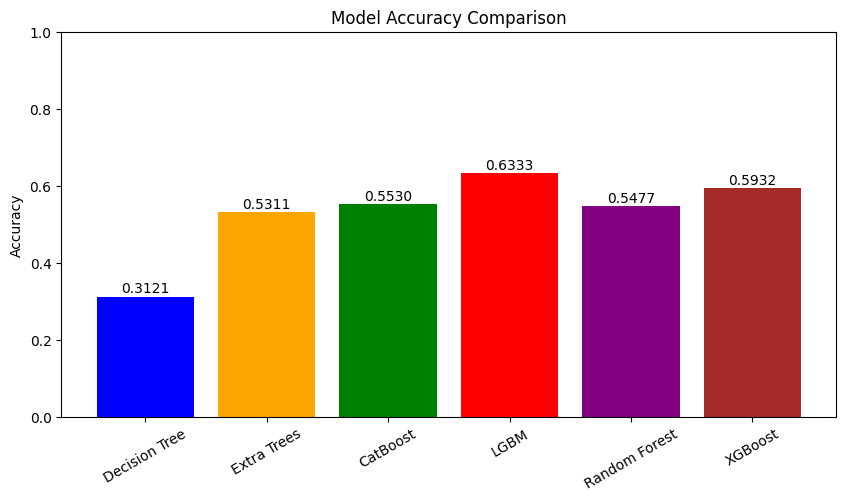

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Tên mô hình và độ chính xác tương ứng
models = ["Decision Tree", "Extra Trees", "CatBoost", "LGBM", "Random Forest", "XGBoost"]
accuracies = [acc_dt, acc_et, acc_cat, acc_lgb, acc_rf, acc_xgb]

# Vẽ biểu đồ cột dọc
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Giới hạn trục y để dễ quan sát

# Hiển thị giá trị trên từng cột
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.01, f"{value:.4f}", ha='center')

plt.xticks(rotation=30)  # Xoay nhãn trục x để dễ đọc
plt.show()


In [32]:
import numpy as np

models = {
    "Random Forest": rf_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        num_used_features = np.sum(model.feature_importances_ > 0)
        print(f"{name}: {num_used_features} features used")


Random Forest: 1060 features used
LightGBM: 873 features used
XGBoost: 900 features used
CatBoost: 590 features used


C:\Users\DO TUAN MINH\AppData\Local\Temp\ipykernel_14932\4262293222.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")
C:\Users\DO TUAN MINH\AppData\Local\Temp\ipykernel_14932\4262293222.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")


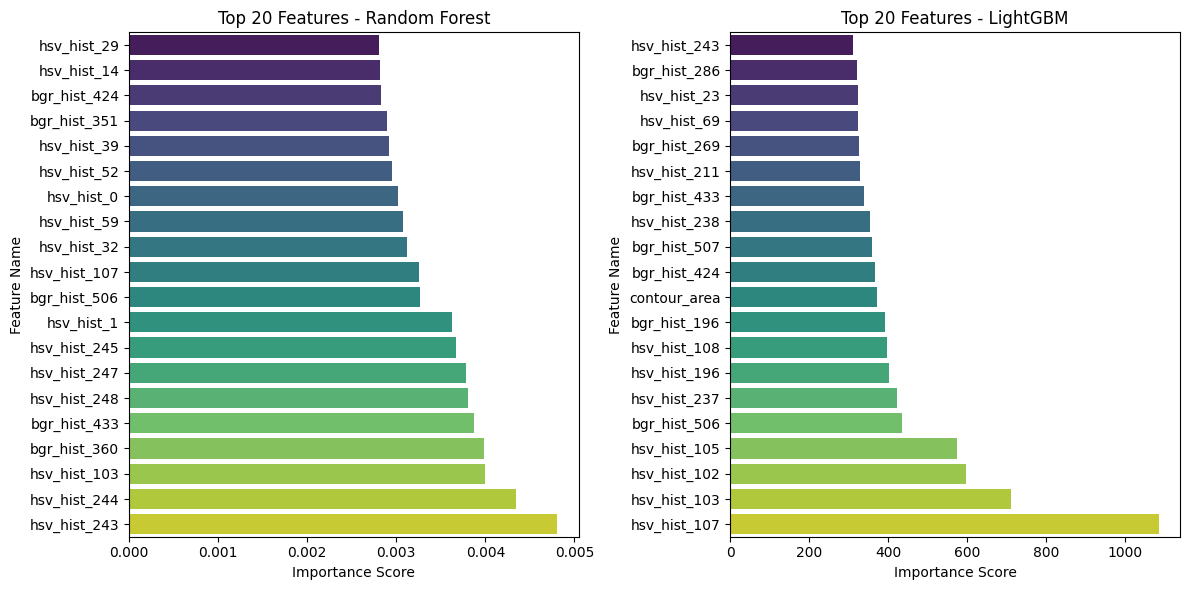

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming these models are trained
models = {
    "Random Forest": rf_model,
    "LightGBM": lgb_model
}

plt.figure(figsize=(12, 6))

for i, (name, model) in enumerate(models.items()):
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[-20:]  # Select top 20
        
        plt.subplot(1, 2, i + 1)
        sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="viridis")
        plt.title(f"Top 20 Features - {name}")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature Name")

plt.tight_layout()
plt.show()


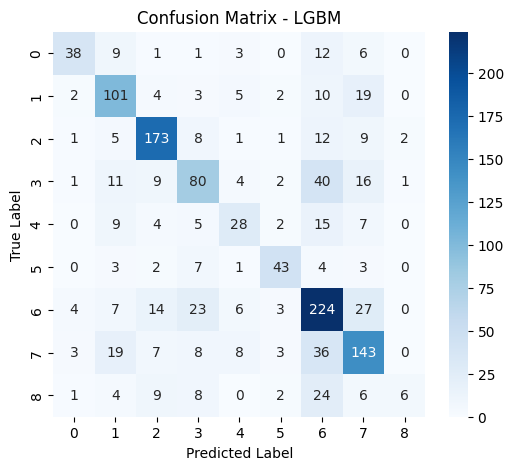

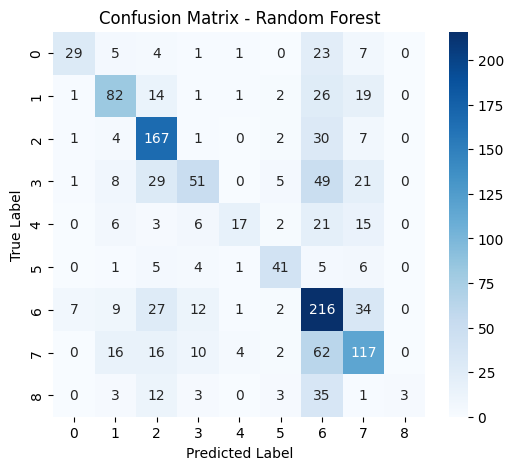

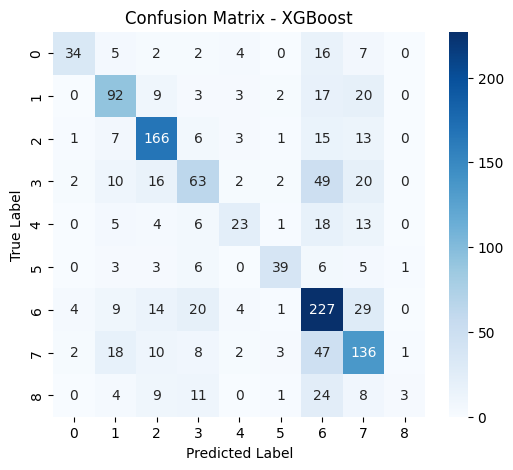

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hàm vẽ Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name} ")
    plt.show()

# Vẽ Confusion Matrix cho từng mô hình
plot_confusion_matrix(y_test, y_pred_lgb, "LGBM")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")


In [46]:
for top_n in [300,400, 500, 600, 700, 800, 900]:
    sorted_idx = np.argsort(feature_importances)[::-1][:top_n]
    X_train_selected = X_train[:, sorted_idx]
    X_test_selected = X_test[:, sorted_idx]

    model = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=300,
        reg_alpha=0.1,
        reg_lambda=0.1,
        class_weight='balanced'
    )
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    print(f"LGBM Accuracy với {top_n} features: {accuracy_score(y_test, y_pred):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76205
[LightGBM] [Info] Number of data points in the train set: 10560, number of used features: 300
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
LGBM Accuracy với 300 features: 0.6189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

In [47]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Train Random Forest ban đầu
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Lấy feature importance
feature_importances = rf_model.feature_importances_

# Danh sách số feature để thử nghiệm
top_n_list = [50, 100, 200, 300, 400, 500]

# Lưu kết quả
results = {}

for top_n in top_n_list:
    sorted_idx = np.argsort(feature_importances)[::-1][:top_n]  
    X_train_selected = X_train[:, sorted_idx]  
    X_test_selected = X_test[:, sorted_idx]  
    
    # Train lại model với features mới
    rf_selected_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
    rf_selected_model.fit(X_train_selected, y_train)

    # Dự đoán và đánh giá
    y_pred_rf_selected = rf_selected_model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred_rf_selected)
    
    results[top_n] = acc
    print(f"Random Forest Accuracy với {top_n} features: {acc:.4f}")

# In ra kết quả tổng hợp
print("📊 Kết quả tổng hợp:", results)


Random Forest Accuracy với 50 features: 0.4894
Random Forest Accuracy với 100 features: 0.5098
Random Forest Accuracy với 200 features: 0.5182
Random Forest Accuracy với 300 features: 0.5326
Random Forest Accuracy với 400 features: 0.5235
Random Forest Accuracy với 500 features: 0.5326
📊 Kết quả tổng hợp: {50: 0.4893939393939394, 100: 0.5098484848484849, 200: 0.5181818181818182, 300: 0.5325757575757576, 400: 0.5234848484848484, 500: 0.5325757575757576}


In [ ]:
adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1), 
    n_estimators=50, 
    learning_rate=1.0, 
    random_state=42
)

# Huấn luyện mô hình
adaboost.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred = adaboost.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc:.4f}')